# Отчет: задание 1

*Неверо Андрей, лабораторная работа 1, 2 курс, 4 группа*

В задании требовалось написать программу, которая эффективно вычисляет обратную матрицу к матрицам почти треугольного вида.

Решением данной задачи можно считать реализацию методов *CountTluDecomposition_AlmostTriangular*, *SolveSystem_AlmostTriangular*, *CountInverseMatrix_TLU_AlmostTriangular*, *CountInverseMatrix_AlmostTriangular* класса Matrix (см. соответствующий заголовочный файл).

Обработка связанных с этим заданием входных данных вынесена в отдельный класс, определенный в заголовочном файле Task1.

## Основная идея алгоритма

Обычный алгоритм нахождения обратной матрицы можно реализовать с помощью LU-разложения. Действительно, найдя LU-разложение, с его помощью можно решить $n$ систем линейных уравнений и таким образом получить все столбцы обратной матрицы. Асимптотическая сложность такого алгоритма равна $O(n^3)$. Но как можно учесть свойства заданных в данной задаче матриц?

Достаточно очевидны два подхода, которые мы и рассмотрим.

Первый подход: можно оптимизировать алгоритм LU-разложения и решения систем линейных уравнений, используя структуру матрицы. Благодаря ей, можно уменьшить асимптотику LU-разложения (с $O(n^3)$ до $O(n^2)$), а также сократить количество операций вычитания (что не повлияет на асимптотику, но улучшит производительность).

Плюс данного подхода: мы сохраняем возможность эффективного распараллеливания алгоритма нахождения обратной матрицы, что в перспективе (на более мощных компьютерах) может сильно улучшить производительность.

Минус данного подхода: на слабых компьютерах (не очень мощные процессоры с 2-4 ядрами) алгоритм будет работать достаточно медленно. 

Второй подход: можно воспользоваться структурой матрицы и быстро привести ее к нижнетреугольному виду (проделав то же самое с соответствующими системами уравнений). Действительно, для этого достаточно отнять последнюю строку от предпоследней, ..., $i$-тую строку от $(i - 1)$-ой, ..., вторую строку от первой. Нахождение обратной матрицы тогда будет достаточно простым: нужно будет всего лишь проделать обратный ход метода Гаусса наоборот (сверху вниз).

Если приводить матрицу к нижнетреугольному виду для каждого столбца отдельно, мы не получим выигрыша во времени по сравнению с первым алгоритмом (скорее всего, даже ухудшим производительность). Соответственно, логично работать над всей матрицей сразу, вычитая сразу целые строки.

Плюс данного подхода: скорее всего, компилятору удастся задействовать возможности модулей SSE и AVX процессора, которые смогут работать с матрицей в векторизованном виде и в разы ускорить операции вычитания строк. Данный эффект будет заметен даже на слабых компьютерах.

Минус данного подхода: не совсем понятно, как эффективно распараллелить данный алгоритм. Как мы увидим ниже, распараллеливание отнимания строк не дает никакого эффекта. При этом возможности SSE и AVX ограничены, когда наращивание количества ядер - гораздо более доступная опция (которая способна сильно увеличить скорость работы алгоритма, основанного на LU-разложении).

## Пункт 1

Найденная обратная матрица выглядит следующим образом (точность до 5 знаков после точки):

$$ X = \begin{bmatrix}
        4.6667 & -2.33333 & -1.66667 & 3.33333 \\
        15 & -7 & -5 & 10 \\
        -6 & 3 & 2 & -4 \\
        -22 & 10 & 7 & -15
\end{bmatrix} $$

Абсолютно точное решение получить не удалось в связи с делением на тройку, но и полученный результат очень неплох (погрешность минимальна). Точность до пяти знаков после запятой обеспечивает как тип *long double*, так и обычный *float*.

## Пункт 2

Заданная матрица является вырожденной: у нее линейно зависимы как минимум первые две строк. Следовательно, нахождение обратной матрицы не представляется возможным.

## Пункт 3

Выясним, какой алгоритм эффективнее всего находит обратную матрицу к нашей матрице специального вида.

Проанализируем время работы обычного алгоритма, основанного на LU-разложении, оптимизированного алгоритма, основанного на LU-разложении, а также специального алгоритма для рассматриваемых матриц, на разных типах вещественных чисел. Для этого воспользуемся функцией *RandomInput* в классе *Task1*.

Данная функция генерирует случайную почти треугольную матрицу определенного размера (значения в матрице - возмущенные от $1$ до $5000$), после чего подсчитывает время работы обычного и оптимизированного алгоритма по нахождению обратной матрицы для трех типов - *float*, *double* и *long double*.

Данная функция запускалась для матриц размером $n = 150k$ до $3000$. Полученные результаты для типов *float*, *double* и *long double* можно увидеть ниже. График красного цвета - график работы обычного алгоритма, основанного на LU-разложении, синего цвета - оптимизированного алгоритма, основанного на LU-разложении, зеленого цвета - специального алгоритма. Величины на оси слева - микросекунды.

При тестировании использовался компьютер с 8-ядерным процессором, все алгоритмы работали в многопоточном режиме (анализ влияния многопоточности на время работы алгоритмов будет приведен чуть ниже).

In [12]:
from data import task1
import matplotlib
%matplotlib inline

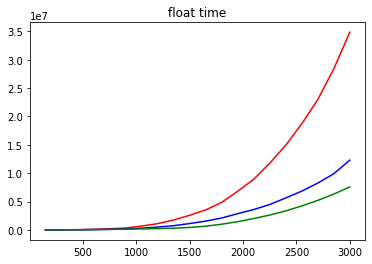

In [13]:
bins = [i for i in range(150, 3001, 150)]
matplotlib.pyplot.title("float time")
matplotlib.pyplot.plot(bins, task1.float_tlu_time, 'r',
                       bins, task1.float_optimized_tlu_time, 'b',
                       bins, task1.float_triangular_time, 'g')
matplotlib.pyplot.show()

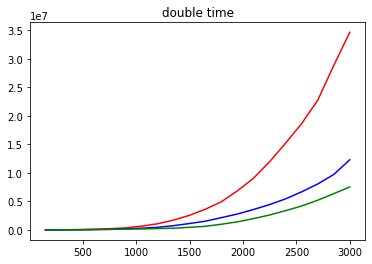

In [14]:
matplotlib.pyplot.title("double time")
matplotlib.pyplot.plot(bins, task1.double_tlu_time, 'r',
                       bins, task1.double_optimized_tlu_time, 'b',
                       bins, task1.double_triangular_time, 'g')
matplotlib.pyplot.show()

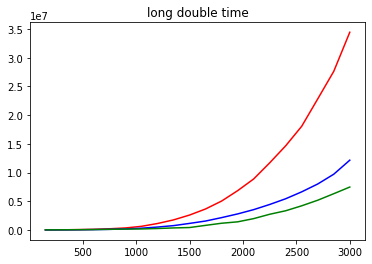

In [15]:
matplotlib.pyplot.title("long double time")
matplotlib.pyplot.plot(bins, task1.long_double_tlu_time, 'r',
                       bins, task1.long_double_optimized_tlu_time, 'b',
                       bins, task1.long_double_triangular_time, 'g')
matplotlib.pyplot.show()

Как видно, уже на матрицах размером $1000$ обычный алгоритм, основанный на LU-разложении, начинает безнадежно отставать от оптимизированных. Хотя оптимизированный алгоритм, основанный на LU-разложении, показывает себя хуже, чем специальный, разница между ними относительно невелика. Вспомним об этом при дальнейшем анализе влияния многопоточности на скорость работы программы.

Сравним для интереса время работы оптимизированного алгоритма, основанного на LU-разложении, а также специального алгоритма, на разных типах вещественных чисел. Желтым цветом обозначен график *long double*, черным - *double*, зеленым - *float*.

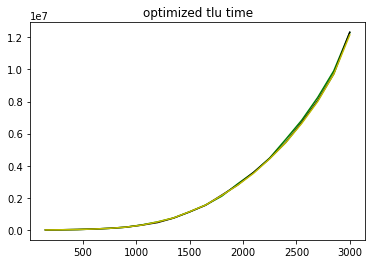

In [16]:
matplotlib.pyplot.title("optimized tlu time")
matplotlib.pyplot.plot(bins, task1.float_optimized_tlu_time, 'g',
                       bins, task1.double_optimized_tlu_time, 'k',
                       bins, task1.long_double_optimized_tlu_time, 'y')
matplotlib.pyplot.show()

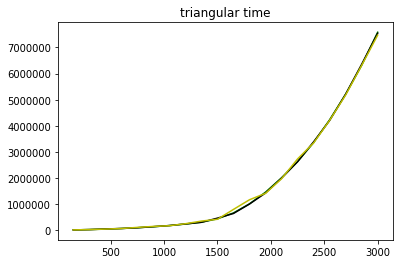

In [17]:
matplotlib.pyplot.title("triangular time")
matplotlib.pyplot.plot(bins, task1.float_triangular_time, 'g',
                       bins, task1.double_triangular_time, 'k',
                       bins, task1.long_double_triangular_time, 'y')
matplotlib.pyplot.show()

Время работы алгоритмов на разных типах вещественных чисел оказалось примерно одинаковым (несмотря на то, что операции с *long double* обычно занимают больше времени, чем операции с *double* и *float*).

Сравним теперь время работы оптимизированного алгоритма, основанного на LU-разложении, в однопоточном и многопоточном режиме. 

Красный график отвечает за однопоточный режим, синий - многопоточный. Использовался тип *double*, размеры матриц - $n = 500k$ до $5000$.

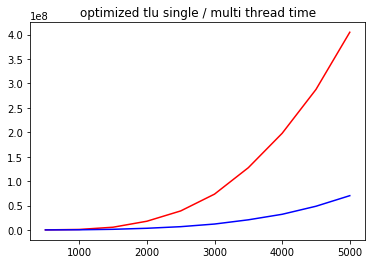

In [18]:
bins = [i for i in range(500, 5001, 500)]
matplotlib.pyplot.title("optimized tlu single / multi thread time")
matplotlib.pyplot.plot(bins, task1.single_thread_optimized_tlu_time, 'r',
                       bins, task1.multi_thread_optimized_tlu_time, 'b')
matplotlib.pyplot.show()

Чем больше размер матрицы, тем больше разница между однопоточным и многопоточным вариантом алгоритма. На матрицах размером $n = 5000$ она составляет $700-800$ процентов. Очевидно, что многопоточность положительным образом влияет на производительность данного алгоритма, и если использовать еще больше ядер, скорость работы программы еще больше увеличится.

Рассмотрим протестированный в аналогичный условиях специальный алгоритм.

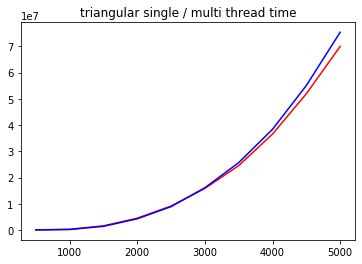

In [19]:
matplotlib.pyplot.title("triangular single / multi thread time")
matplotlib.pyplot.plot(bins, task1.single_thread_triangular_time, 'r',
                       bins, task1.multi_thread_triangular_time, 'b')
matplotlib.pyplot.show()

Как видно, многопоточность никак не влияет на скорость работы специального алгоритма (небольшие различия можно списать на погрешность при измерениях).

Сравним многопоточные версии оптимизированного алгоритма, основанного на LU-разложении, и специального алгоритма. Первый выделен синим цветом, второй - красным.

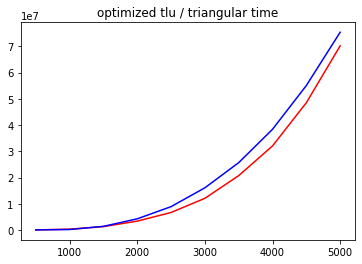

In [20]:
matplotlib.pyplot.title("optimized tlu / triangular time")
matplotlib.pyplot.plot(bins, task1.multi_thread_optimized_tlu_time, 'r',
                       bins, task1.multi_thread_triangular_time, 'b')
matplotlib.pyplot.show()

Нетрудно видеть, что время работы двух алгоритмов почти не отличается.

## Особенности работы алгоритмов на разных компьютерах

Дабы сделать корректные выводы, не лишним будет отметить некоторые особенности работы тестируемых алгоритмов на различных компьютерах.

Во-первых, следует отметить, что различия в скорости работы на разных типах вещественных чисел (*float*, *double*, *long double*) почти отсутствовали лишь на компьютере с процессором Intel одного из последних поколений. Возможно, это стало следствием каких-либо улучшений архитектуры (либо особенностью, например, компилятора). На компьютере с более старым процессором все алгоритмы вели себя так, как "обычно" и ведут: *float*-матрицы обрабатывались быстрее, чем *double*, а *double* - быстрее, чем *long double*. В частности, за минуту специальный алгоритм на компьютере с двухядерным мобильным процессором Intel 4-го поколения обработал:
* Матрицу размером $n \approx 5900$ типа *float*
* Матрицу размером $n \approx 4600$ типа *double*
* Матрицу размером $n \approx 3500$ типа *long double*

Во-вторых, следует подтвердить высказанное ранее утверждение о том, что количество ядер прямым образом влияет на время работы оптимизированного алгоритма, основанного на LU-разложении. На уже упомянутом компьютере с двухядерным процессором такой алгоритм за минуту обрабатывает матрицу лишь размером около $\approx 2500$. При этом на компьютере с восьмиядерным процессором, как можно увидеть на графике, мы приходим к матрицам размером $\approx 4600$.

В-третьих, следует подтвердить высказанное ранее утверждение о том, что количество ядер никак не влияет на время работы специального алгоритма. Он обрабатывает матрицу размером $\approx 4600$ за минуту как на компьютере с более старым двухядерным процессором, так и на компьютере с новым восьмиядерным процессором.

## Выводы

Исходя из приведенной выше информации, можно сделать следующие выводы:
* Если необходимо работать с матрицами размера больше $2000$, следует выбрать оптимизированный алгоритм, основанный на LU-разложении, а также найти компьютер с большим количеством ядер. При достаточном количестве ядер данный алгоритм гипотетически обойдет специальный по скорости работы.
* Если необходимо работать с матрицами размером от $1000$ до $2000$, следует выбрать специальный алгоритм. Он быстро отработает на любом компьютере (и мощном, и не столь мощном).
* При работе с матрицами размером до $1000$ можно выбрать любой алгоритм (даже обычный, основанный на LU-разложении). Функционировать все они будут примерно с одинаковой скоростью.